In [1]:
import glob
import numpy as np
import ROOT
import random
from scipy import interpolate, optimize

Welcome to JupyROOT 6.26/04


In [2]:
filesER = glob.glob("/home/smalu/Documents/NSC_veto_ER_NR/Pulse/*ER*.txt")
filesNR = glob.glob("/home/smalu/Documents/NSC_veto_ER_NR/Pulse/*NR*.txt")

In [17]:
%jsroot on

In [3]:
#writing pulses into arrays
number_ER = len(filesER)
number_NR = len(filesNR)
pulsesER = {}
primaryPulsesER = []
energiesER = []
counter = 0
for index, file in enumerate(filesER):
    pulse = {}
    #print(file)
    #print(round(float(file.split('/')[6].split('_')[1][:-3]), 1))
    energy = round(float(file.split('/')[6].split('_')[1][:-3]), 1)
    for i in range(4):
        pulse[i] = []
    with open(file) as f:
        for line in f:
            for i in range(4):
                pulse[i].append(float(line.split()[i]))
    primaryCh = np.argmax([max(pulse[0]),max(pulse[1]),max(pulse[2]),max(pulse[3])])
    if energy>0.5:
        pulsesER[counter] = pulse
        primaryPulsesER.append(pulse[primaryCh])
        energiesER.append(energy)
        counter+=1
        
pulsesNR = {}
primaryPulsesNR = []
energiesNR = []
counter = 0
for index, file in enumerate(filesNR):
    pulse = {}
    energy = round(float(file.split('/')[6].split('_')[1][:-3]), 1)
    for i in range(4):
        pulse[i] = []
    with open(file) as f:
        for line in f:
            for i in range(4):
                pulse[i].append(float(line.split()[i]))
    primaryCh = np.argmax([max(pulse[0]),max(pulse[1]),max(pulse[2]),max(pulse[3])])
    if energy>0.5:
        pulsesNR[counter] = pulse
        primaryPulsesNR.append(pulse[primaryCh])
        energiesNR.append(energy)
        counter+=1

In [4]:
nSamples = len(pulsesER[0][0])
print("Number of ER pulses: "+str(len(energiesER)))
print("Number of NR pulses: "+str(len(energiesNR)))

Number of ER pulses: 742
Number of NR pulses: 80


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cPulses


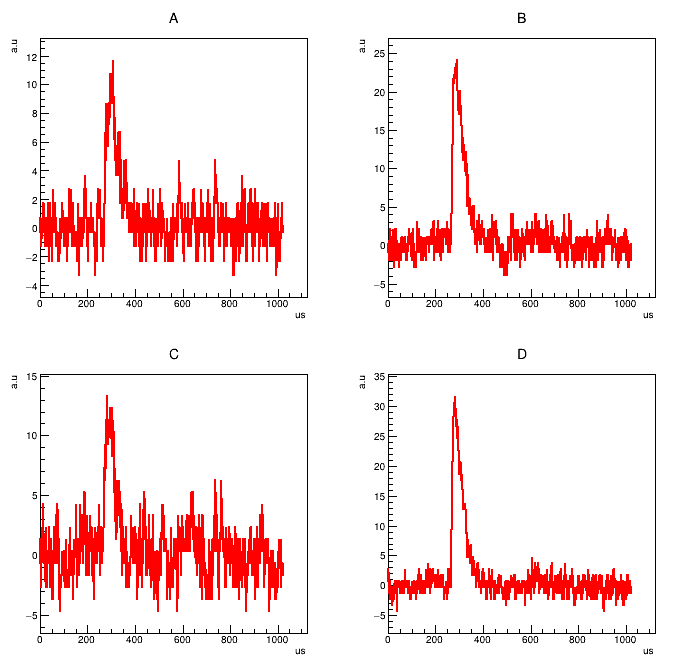

In [16]:
#plotting some of the ER pulses (All Channes)
#testing purposes
channels = ['A', 'B', 'C', 'D']
nSamples = len(pulsesER[0][0])
n = random.randint(0, len(pulsesER))
pulseGraphs = {}
X = [float(i) for i in range(nSamples)]
X = np.array(X)
for i in range(4):
    Y = np.array(pulsesER[n][i])
    pulseGraphs[i] = ROOT.TGraph(nSamples,X, Y)

cPulses= ROOT.TCanvas("cPulses", "", 700, 700)
cPulses.Divide(2,2)
for i in range(4):
    cPulses.cd(i+1)
    
    pulseGraphs[i].SetLineColor(ROOT.kRed)
    pulseGraphs[i].SetMarkerColor(ROOT.kRed)
    pulseGraphs[i].SetLineWidth(2)
    pulseGraphs[i].SetTitle(channels[i])
    #pulseGraphs[i].GetXaxis().SetRangeUser(0.75e6, 1e6)
    #pulseGraphs[i].GetYaxis().SetRangeUser(-.1e-6, 0.7e-6)
    pulseGraphs[i].GetXaxis().SetTitle('us')
    pulseGraphs[i].GetYaxis().SetTitle('a.u')
    pulseGraphs[i].GetYaxis().SetTitleOffset(1.4)
    #pulseGraphs[i].SetTitle('Energy: '+str(round(energy[ch][i],2))+" keV, Chi2: "+str(round(chi2s_arr[ch][i])))
    pulseGraphs[i].Draw()

cPulses.Draw()

In [17]:
#function calculates rise timestamp given the pulse and the percentage
def calcRise(pulse, pct):
    pmax = max(pulse)
    maxbin = np.argmax(pulse)
    result = 0
    time = [float(i) for i in range(nSamples)]
    time = np.array(time)
    for i in range(int(nSamples / 4)):
        if pulse[maxbin - i] < pct * pmax and maxbin - i > 0:
            y = np.array(
                  [pulse[maxbin - i - 1], pulse[maxbin - i], pulse[maxbin - i + 1], pulse[maxbin - i + 2]])
            x = np.array(
                  [time[maxbin - i - 1], time[maxbin - i], time[maxbin - i + 1], time[maxbin - i + 2]])
            f1 = interpolate.interp1d(x, y, kind='linear')
            g = lambda x: f1(x) - pct * pmax
            try:
                result = optimize.newton(g, time[maxbin - i])
            except (ValueError, RuntimeError):
                result = 0
            break
    return result

In [18]:
#calculating rise timestamps
primaryRiseER10 = []
primaryRiseER40 = []
primaryRiseER90 = []
for i in range(len(primaryPulsesER)):
    primaryRiseER10.append(calcRise(primaryPulsesER[i],.1))
    primaryRiseER40.append(calcRise(primaryPulsesER[i],.4))
    primaryRiseER90.append(calcRise(primaryPulsesER[i],.9))
    
primaryRiseNR10 = []
primaryRiseNR40 = []
primaryRiseNR90 = []
for i in range(len(primaryPulsesNR)):
    primaryRiseNR10.append(calcRise(primaryPulsesNR[i],.1))
    primaryRiseNR40.append(calcRise(primaryPulsesNR[i],.4))
    primaryRiseNR90.append(calcRise(primaryPulsesNR[i],.9))

In [19]:
#Histograms with rise time distribution
nbins = 25
riseER1 = ROOT.TH1F("riseER1", "", nbins, 0.0, 15)
riseNR1 = ROOT.TH1F("riseNR1", "", nbins, 0.0, 15)
riseER = ROOT.TH1F("riseER", "", nbins, 0.0, 15)
riseNR = ROOT.TH1F("riseNR", "", nbins, 0.0, 15)
rise_vs_energy = ROOT.TH2F("rise_vs_energy", "", nbins, 1, 5, nbins, 0.0, 15)
rise_vs_energy1 = ROOT.TH2F("rise_vs_energy1", "", nbins, 1, 5, nbins, 0.0, 15)
for i in range(len(primaryPulsesER)):
    riseER1.Fill(primaryRiseER90[i]-primaryRiseER10[i])
    rise_vs_energy.Fill(energiesER[i], primaryRiseER90[i]-primaryRiseER10[i])
for i in range(len(primaryPulsesNR)):
    riseNR1.Fill(primaryRiseNR90[i]-primaryRiseNR10[i])
    rise_vs_energy1.Fill(energiesNR[i], primaryRiseNR90[i]-primaryRiseNR10[i])
    
for i in range(nbins):
    a = riseER1.GetBinContent(i)
    riseER.SetBinContent(i, a/len(energiesER))
for i in range(nbins):
    a = riseNR1.GetBinContent(i)
    riseNR.SetBinContent(i, a/len(energiesNR))

Warning in <TROOT::Append>: Replacing existing TH1: riseER1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: riseNR1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: riseER (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: riseNR (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: rise_vs_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: rise_vs_energy1 (Potential memory leak).


340
332
35
216
285
450


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cPulseComparison


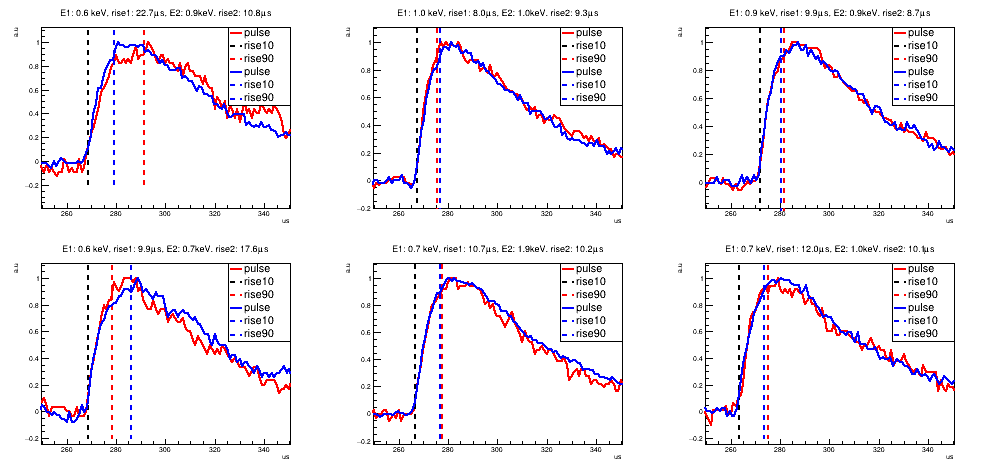

In [20]:
# randomly selected and overlaid pulses
legend, line10, line40, line90, template_label, line10_1, line40_1, line90_1 = {}, {}, {}, {}, {}, {}, {}, {}
pulse_graphs, pulse_graphs1 = {}, {}
cPulseComparison = ROOT.TCanvas("cPulseComparison", "", 1000, 500)
nx = 3
ny = 2
cPulseComparison.Divide(nx,ny)
for k in range(nx*ny):
    i = random.randint(0,len(primaryPulsesER)-1)
    j = random.randint(0,len(primaryPulsesNR)-1)
    
    print(i)
    
    cPulseComparison.cd(k+1)
    minX = 250
    maxX = 350
    
    X = [float(i) for i in range(nSamples)]
    X = np.array(X)
    Y = np.array(primaryPulsesER[i])
    amp1 = max(Y)
    Y /= max(Y)
    pulse_graphs[k] = ROOT.TGraph(len(Y), X, Y)
    
    maxY = 1.1
    minY = -0.2
    
    pulse_graphs[k].SetLineColor(ROOT.kRed)
    pulse_graphs[k].SetMarkerColor(ROOT.kRed)
    pulse_graphs[k].SetLineWidth(2)
    pulse_graphs[k].GetXaxis().SetRangeUser(minX, maxX)
    #pulse_graphs[k].GetYaxis().SetRangeUser(minY, maxY)
    pulse_graphs[k].GetXaxis().SetTitle('us')
    pulse_graphs[k].GetYaxis().SetTitle('a.u')
    pulse_graphs[k].GetYaxis().SetTitleOffset(1.4)
    pulse_graphs[k].SetTitle("E1: "+str(energiesER[i])+" keV, rise1: "+str(round((primaryRiseER90[i]-primaryRiseER10[i]), 1))\
                           +"#mus, E2: "+str(energiesNR[j])+"keV. rise2: "+str(round((primaryRiseNR90[j]-primaryRiseNR10[j]), 1))+'#mus')
    pulse_graphs[k].Draw()
    
    line10[k] = ROOT.TLine(primaryRiseER10[i], minY, primaryRiseER10[i], maxY)
    line10[k].SetLineColor(ROOT.kBlack)
    line10[k].SetLineStyle(7)
    line10[k].SetLineWidth(2)
    line10[k].Draw("SAME")
    
    line40[k] = ROOT.TLine(primaryRiseER40[i], minY, primaryRiseER40[i], maxY)
    line40[k].SetLineColor(ROOT.kOrange)
    line40[k].SetLineStyle(7)
    line40[k].SetLineWidth(2)
    #line40[i].Draw("SAME")
    
    line90[k] = ROOT.TLine(primaryRiseER90[i], minY, primaryRiseER90[i], maxY)
    line90[k].SetLineColor(ROOT.kRed);
    line90[k].SetLineStyle(7);
    line90[k].SetLineWidth(2);
    line90[k].Draw("SAME")

    legend[k] = ROOT.TLegend(0.7,0.555,0.9,0.9)
    legend[k].AddEntry(pulse_graphs[k],"pulse","l")
    legend[k].AddEntry(line10[k],"rise10","l")
    #legend[i].AddEntry(line40[k],"rise40","l")
    legend[k].AddEntry(line90[k],"rise90","l")
    legend[k].Draw("SAME")
    
    #template_label[i] = ROOT.TLatex(minX+.5*(maxX-minX),0.9*maxY,"Template "+str(template_number[ch][i]+1))
    #template_label[i].Draw("SAME")
    
    X_shift = primaryRiseNR10[j] - primaryRiseER10[i]
    X-=X_shift
    Y = np.array(primaryPulsesNR[j])
    amp2 = max(Y)
    Y /= max(Y)
    pulse_graphs1[k] = ROOT.TGraph(len(Y), X, Y)
    
    pulse_graphs1[k].SetLineColor(ROOT.kBlue)
    pulse_graphs1[k].SetMarkerColor(ROOT.kBlue)
    pulse_graphs1[k].SetLineWidth(2)
    pulse_graphs1[k].Draw("SAME")
    
    line10_1[k] = ROOT.TLine(primaryRiseNR10[j], minY, primaryRiseNR10[j], maxY);
    line10_1[k].SetLineColor(ROOT.kBlue);
    line10_1[k].SetLineStyle(7);
    line10_1[k].SetLineWidth(2);
    #line10_1[k].Draw("SAME")
    
    line40_1[k] = ROOT.TLine(primaryRiseNR40[j], minY, primaryRiseNR40[j], maxY);
    line40_1[k].SetLineColor(ROOT.kBlue);
    line40_1[k].SetLineStyle(7);
    line40_1[k].SetLineWidth(2);
    #line40_1[i].Draw("SAME")
    
    line90_1[k] = ROOT.TLine(primaryRiseNR90[j]-X_shift, minY, primaryRiseNR90[j]-X_shift, maxY)
    line90_1[k].SetLineColor(ROOT.kBlue)
    line90_1[k].SetLineStyle(7)
    line90_1[k].SetLineWidth(2)
    line90_1[k].Draw("SAME")
    
    legend[k].AddEntry(pulse_graphs1[k],"pulse","l")
    legend[k].AddEntry(line10_1[k],"rise10","l")
    #legend[k].AddEntry(line40_1[k],"rise40","l")
    legend[k].AddEntry(line90_1[k],"rise90","l")
    legend[k].Draw("SAME")
cPulseComparison.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cRise


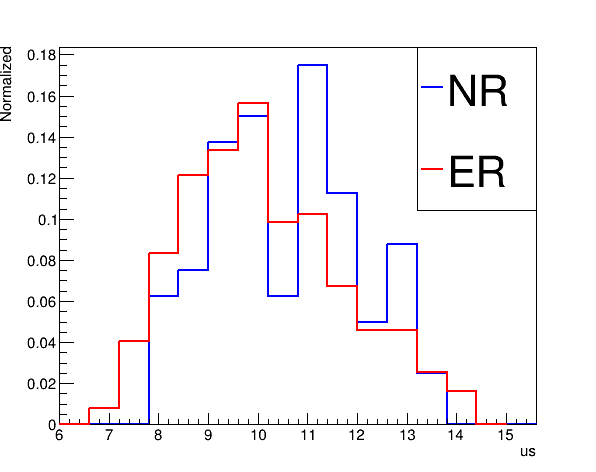

In [21]:
cRise = ROOT.TCanvas("cRise", "", 600, 500)
cRise.cd()
riseNR.SetStats(0)
riseNR.SetLineColor(ROOT.kBlue)
riseNR.SetLineWidth(2)
riseNR.GetXaxis().SetRangeUser(6, 18)
riseNR.GetXaxis().SetTitle('us')
riseNR.GetYaxis().SetTitle('Normalized')
riseNR.GetYaxis().SetTitleOffset(1.6)
riseNR.Draw()
riseER.SetLineColor(ROOT.kRed)
riseER.SetLineWidth(2)
riseER.Draw("SAME")

legend = ROOT.TLegend(0.7,0.555,0.9,0.9)
legend.AddEntry(riseNR,"NR","l")
legend.AddEntry(riseER,"ER","l")
legend.Draw("SAME")
cRise.Draw()

###### 

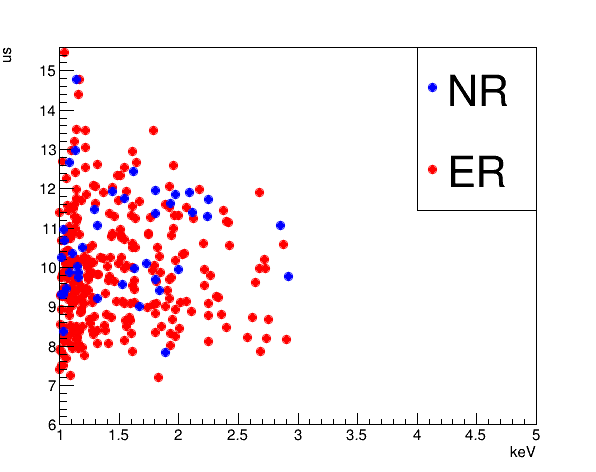

In [22]:
cRise_vs_energy = ROOT.TCanvas("cRise_vs_energy", "", 600, 500)
cRise_vs_energy.cd()
rise_vs_energy.SetStats(0)
rise_vs_energy.SetMarkerColor(ROOT.kRed)
rise_vs_energy.SetMarkerStyle(8)
rise_vs_energy.SetMarkerSize(1)
rise_vs_energy.GetYaxis().SetRangeUser(6, 18)
rise_vs_energy.GetYaxis().SetTitle('us')
rise_vs_energy.GetXaxis().SetTitle('keV')
rise_vs_energy.GetYaxis().SetTitleOffset(1.6)
rise_vs_energy.Draw()
rise_vs_energy1.SetMarkerColor(ROOT.kBlue)
rise_vs_energy1.SetMarkerStyle(8)
rise_vs_energy1.SetMarkerSize(1)
rise_vs_energy1.Draw("SAME")

legend = ROOT.TLegend(0.7,0.555,0.9,0.9)
legend.AddEntry(rise_vs_energy1,"NR","p")
legend.AddEntry(rise_vs_energy,"ER","p")
legend.Draw("SAME")
cRise_vs_energy.Draw()